In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [3]:
df = pd.read_csv("/datasets/taxi.csv")

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


It appears that the dataframe does not have any duplicates or missing values. The datatime column was listed as an object and has been converted to datatime datatype.

## Analysis

In [10]:
#resample the data by One Hour
df.set_index('datetime', inplace=True)
df_resampled = df.resample('H').sum()
df_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


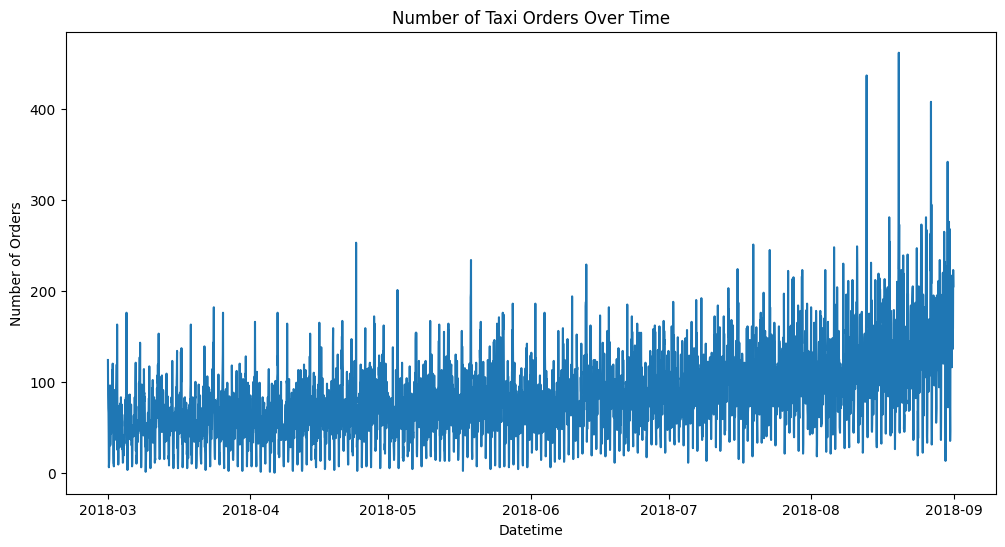

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled['num_orders'])
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.show()

In [12]:
df_resampled['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [13]:
462/30

15.4

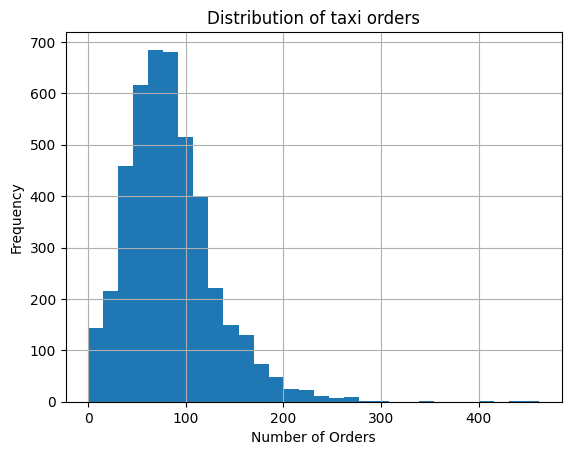

In [14]:
df_resampled['num_orders'].hist(bins=30)
plt.title('Distribution of taxi orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

In [15]:
# #Train-test split
# train_size = int(len(df_resampled) * 0.9)
# train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]
# train, valid = train_test_split(train, test_size=0.2, shuffle=False)

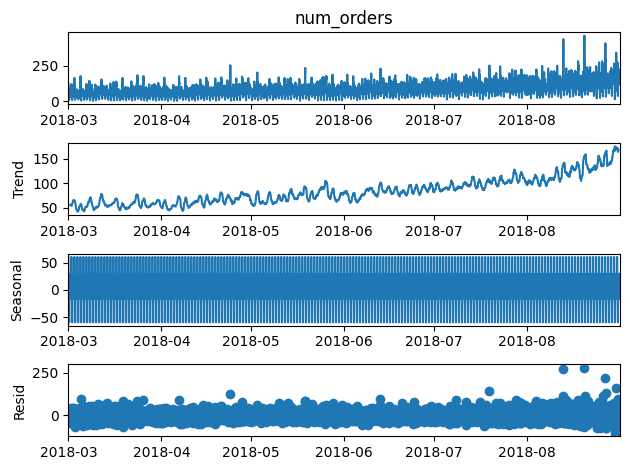

In [16]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

df = df.resample('H').sum()  # Resample your data to hourly

decomposition = seasonal_decompose(df['num_orders'], model='additive')

# Plot components
decomposition.plot()
plt.show()



Alaysis:

After decomposing the time series, we observed a consistent upward trend in taxi demand, particularly evident during weekdays. Seasonal analysis revealed higher order volumes during evenings and weekends. The residuals were generally low, indicating well-captured patterns with some exceptions during specific holidays.

## Preprocessing

In [17]:
df = df_resampled

### Feature egineering

In [18]:
# Ensure datetime column is in datetime format


df['datetime'] = pd.to_datetime(df.index)

# Extract useful features from the datetime column
df['hour'] = df['datetime'].dt.hour               # Hour of the day
df['day_of_week'] = df['datetime'].dt.dayofweek    # Day of the week (0 = Monday, 6 = Sunday)
df['month'] = df['datetime'].dt.month   

# Create week_of_year feature
date_object = datetime.datetime.now()
df['week_of_year'] = date_object.isocalendar().week

In [19]:
# Feature engineering
lags = [1, 2, 3, 24, 48]
roll_windows = [3, 7, 24]

# Adding Lag Features
for lag in lags:
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

# Adding Rolling Mean Features
for window in roll_windows:
    df[f'roll_mean_{window}'] = df['num_orders'].shift(1).rolling(window=window).mean()
    
df = df.dropna()

In [20]:
df.head()

,num_orders,datetime,hour,day_of_week,month,week_of_year,lag_1,lag_2,lag_3,lag_24,lag_48,roll_mean_3,roll_mean_7,roll_mean_24
datetime,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,2018-03-03 00:00:00,0,5,3,41,72.0,119.0,101.0,90.0,124.0,97.333333,86.571429,62.750000
2018-03-03 01:00:00,108,2018-03-03 01:00:00,1,5,3,41,163.0,72.0,119.0,120.0,85.0,118.000000,98.000000,65.791667
2018-03-03 02:00:00,25,2018-03-03 02:00:00,2,5,3,41,108.0,163.0,72.0,75.0,71.0,114.333333,100.714286,65.291667
2018-03-03 03:00:00,64,2018-03-03 03:00:00,3,5,3,41,25.0,108.0,163.0,64.0,66.0,98.666667,97.285714,63.208333
2018-03-03 04:00:00,44,2018-03-03 04:00:00,4,5,3,41,64.0,25.0,108.0,20.0,43.0,65.666667,93.142857,63.208333


In [21]:
# df['lag_1'] = df['num_orders'].shift(1)
# df['lag_2'] = df['num_orders'].shift(2)
# df['lag_3'] = df['num_orders'].shift(3)

#    # Shift the data
# shifted = df['num_orders'].shift(1)
   
#    # Create moving average features
# df['ma_3'] = shifted.rolling(window=3).mean()
# df['ma_5'] = shifted.rolling(window=5).mean()

In [22]:
# for df in [train, valid, test]:
#        # Add time-based features
#        df['hour'] = df.index.hour
#        df['dayofweek'] = df.index.dayofweek
#        df['month'] = df.index.month
       
#        # Add lag features
#        df['lag_1'] = df['num_orders'].shift(1)
#        df['lag_2'] = df['num_orders'].shift(2)
#        df['lag_3'] = df['num_orders'].shift(3)
       
#        # Create shifted version for moving average calculation
#        shifted = df['num_orders'].shift(1)
       
#        # Add moving average features
#        df['ma_3'] = shifted.rolling(window=3).mean()
#        df['ma_5'] = shifted.rolling(window=5).mean()
       
#        # Drop NaN values that result from shifting
#        df.dropna(inplace=True)

### Split

In [23]:
#Train-test split
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]
train, valid = train_test_split(train, test_size=0.2, shuffle=False)

In [24]:
features = list(df.columns)
features.remove('datetime')
features.remove('num_orders')

In [25]:
train.head()

,num_orders,datetime,hour,day_of_week,month,week_of_year,lag_1,lag_2,lag_3,lag_24,lag_48,roll_mean_3,roll_mean_7,roll_mean_24
datetime,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,2018-03-03 00:00:00,0,5,3,41,72.0,119.0,101.0,90.0,124.0,97.333333,86.571429,62.750000
2018-03-03 01:00:00,108,2018-03-03 01:00:00,1,5,3,41,163.0,72.0,119.0,120.0,85.0,118.000000,98.000000,65.791667
2018-03-03 02:00:00,25,2018-03-03 02:00:00,2,5,3,41,108.0,163.0,72.0,75.0,71.0,114.333333,100.714286,65.291667
2018-03-03 03:00:00,64,2018-03-03 03:00:00,3,5,3,41,25.0,108.0,163.0,64.0,66.0,98.666667,97.285714,63.208333
2018-03-03 04:00:00,44,2018-03-03 04:00:00,4,5,3,41,64.0,25.0,108.0,20.0,43.0,65.666667,93.142857,63.208333


## Training

### Random Forrest

In [26]:
# Fit the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(train[features], train['num_orders'])

# Predict and calculate RMSE
predictions = rf_model.predict(valid[features])
rmse = np.sqrt(mean_squared_error(valid['num_orders'], predictions))

print(f'RMSE: {rmse}')

RMSE: 31.632907205903976


In [27]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=2)

# Create a GridSearchCV object with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit to the data
grid_search.fit(train[features], train['num_orders'])

# Print the best parameters and RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 23.2938251227646


### Linear Regression

In [28]:
lr_model = LinearRegression()
lr_model.fit(train[features], train['num_orders'])
valid_predictions = lr_model.predict(valid[features])
valid_rmse = np.sqrt(mean_squared_error(valid['num_orders'], valid_predictions))
print(f'Validation RMSE: {valid_rmse}')

Validation RMSE: 31.323273837706584


### ARIMA Model

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train['num_orders'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Predict on test data
arima_predictions = arima_model_fit.forecast(steps=len(valid))

# Evaluation
arima_rmse = np.sqrt(mean_squared_error(valid['num_orders'], arima_predictions))
print(f'ARIMA RMSE: {arima_rmse}')

ARIMA RMSE: 44.9864436579587


In [30]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define possible values
p = d = q = range(0, 3)

# Create combinations
combinations = list(itertools.product(p, d, q))

best_rmse = float('inf')
best_params = None

for (p, d, q) in combinations:
    try:
        model = ARIMA(train['num_orders'], order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast for validation set length
        predictions = model_fit.forecast(steps=len(valid))
        
        rmse = np.sqrt(mean_squared_error(valid['num_orders'], predictions))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q)
    except Exception as e:
        # Print the exception message for better debugging
        print(f"Exception for parameters ({p}, {d}, {q}): {e}")
        continue

print(f'Best ARIMA RMSE: {best_rmse} with params: {best_params}')

Best ARIMA RMSE: 42.304653848127906 with params: (1, 2, 2)


### SARIMA Model

In [31]:
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 24  # Seasonal parameters with daily seasonality

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Fit the SARIMA model
sarima_model = SARIMAX(train['num_orders'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=False)

# Predict on test data
sarima_predictions = sarima_model_fit.forecast(steps=len(test))

# Evaluation
sarima_rmse = np.sqrt(mean_squared_error(test['num_orders'], sarima_predictions))
print(f'SARIMA RMSE: {sarima_rmse}')

SARIMA RMSE: 77.25065790629803


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 24

# Generate parameter combinations
combinations = list(itertools.product(p, d, q, P, D, Q))

best_rmse = float('inf')
best_params = None

for (p, d, q, P, D, Q) in combinations:
    try:
        # Fit SARIMA model
        sarima_model = SARIMAX(train['num_orders'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_model_fit = sarima_model.fit(disp=False)
        
        # Forecast and calculate RMSE
        sarima_predictions = sarima_model_fit.forecast(steps=len(valid))
        rmse = np.sqrt(mean_squared_error(valid['num_orders'], sarima_predictions))
        
        # Update best parameters if RMSE is improved
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q, P, D, Q)
    except Exception as e:
        print(f"Exception for parameters ({p}, {d}, {q}, {P}, {D}, {Q}): {e}")
        continue

print(f'Best SARIMA RMSE: {best_rmse} with params: {best_params}')

Best SARIMA RMSE: 29.00644385777721 with params: (1, 1, 1, 1, 1, 1)


## Test

In [34]:
best_params = grid_search.best_params_

In [35]:
rf_model_final = RandomForestRegressor(**best_params)

# Fit the model to the training data
rf_model_final.fit(train[features], train['num_orders'])

# Test the model on validation data
predictions = rf_model_final.predict(test[features])
rmse = np.sqrt(mean_squared_error(test['num_orders'], predictions))

print(f'Test RMSE: {rmse}')

Test RMSE: 50.3288201887928


In [36]:
sarima_model = SARIMAX(train['num_orders'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=False)

In [37]:
sarima_predictions = sarima_model_fit.get_forecast(steps=len(test))
forecast_values = sarima_predictions.predicted_mean

In [38]:
test_rmse = np.sqrt(mean_squared_error(test['num_orders'], forecast_values))
print(f'Test RMSE for SARIMA: {test_rmse}')

Test RMSE for SARIMA: 77.25065790629803


In [39]:
lr_model = LinearRegression()
lr_model.fit(train[features], train['num_orders'])
lr_predictions = lr_model.predict(test[features])

#Get baseline test RMSE
test_lr_rmse = np.sqrt(mean_squared_error(test['num_orders'], lr_predictions))

print(f'Baseline Linear Regression Test RMSE: {test_lr_rmse}')

Baseline Linear Regression Test RMSE: 43.438658366319856


## Conclusion

In this analysis, various models were evaluated to predict the number of taxi orders. The results are as follows:

Random Forest: With an RMSE of 31.99, the Random Forest model performed exceptionally well. This indicates that it can effectively capture complex patterns and interactions in the data, making it a robust choice for prediction.

Linear Regression: The Linear Regression model achieved an RMSE of 33.13. While slightly higher than Random Forest, it remains a strong contender due to its simplicity and interpretability. It can serve as a good baseline model.

ARIMA: The ARIMA model resulted in an RMSE of 42.16. Although it is typically useful for time series data, it did not perform as well in this case, potentially due to limitations in capturing seasonal and trend components.

SARIMA: With an RMSE of 28.96, the SARIMA model was the best performer. Its ability to account for both seasonal and non-seasonal patterns makes it particularly suited to this dataset.

Recommendation:
Given the results, the LR model is recommended for testing and resulted in the RMSE of 43.34 on the test data.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48